In [1]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Sampler,SubsetRandomSampler

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter
import pytorch_forecasting as pyf

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [2]:
G = nx.readwrite.read_gpickle('data/czech_road_network.p')
nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})

In [3]:
# Pytorch geometric Data object.
pyg_data = from_networkx(G)
pyg_data.to(device);
pyg_data

Data(edge_index=[2, 2328], id=[1128], num_nodes=1128)

In [4]:
avg_speed = pd.read_csv('data/avg_speed.csv')
# avg_speed = avg_speed.fillna(method='ffill')
avg_speed = avg_speed.fillna(avg_speed.mean())
avg_speed.tail(3)

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I58-009,I58-010,I58-011,I58-012,I58-013,I58-014,I63-001,I63-002,I63-003,I63-004
3041,2022-02-18 11:15:00,77.094997,78.360001,77.630001,85.760002,85.125000,79.240002,82.045002,83.419998,81.875000,...,85.494999,76.519997,86.935001,84.414997,87.215000,79.564999,66.505001,74.355000,77.430000,59.590000
3042,2022-02-18 11:30:00,73.864998,76.584999,76.165001,85.764999,87.189999,79.549999,80.314999,82.230003,76.325001,...,70.940002,64.989998,78.313228,75.225002,79.700001,74.020000,60.510002,84.954998,85.430000,60.919998
3043,2022-02-18 11:45:00,74.625000,78.560001,76.619999,86.230000,85.099998,79.410000,82.834999,81.520000,51.759998,...,77.121068,69.458928,78.313228,74.466565,83.621203,78.275549,68.955525,81.143373,80.467761,63.498577


In [5]:
intensity = pd.read_csv('data/intensity.csv')
# intensity = intensity.fillna(method='ffill')
intensity = intensity.fillna(0)
intensity.tail(3)

,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I58-009,I58-010,I58-011,I58-012,I58-013,I58-014,I63-001,I63-002,I63-003,I63-004
3041,2022-02-18 11:15:00,57,51,73,58,59,44,43.0,49,58,...,9.0,5.0,5.0,12.0,9.0,18.0,19.0,6.0,6.0,4.0
3042,2022-02-18 11:30:00,55,55,63,57,48,37,47.0,39,45,...,1.0,1.0,0.0,5.0,13.0,10.0,22.0,5.0,4.0,3.0
3043,2022-02-18 11:45:00,46,50,72,57,51,39,37.0,41,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
nodes = intensity.columns[1:].to_list()
nodes[:5]

['D00-001', 'D00-002', 'D00-003', 'D00-004', 'D00-005']

In [7]:
len(nodes)

1128

In [8]:
pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in nodes]))
pyg_data.id = nodes
pyg_data

Data(edge_index=[2, 2328], id=[1128], num_nodes=1128)

In [177]:
class StandardScaler(nn.Module):
    def fit(self, x):
        x = x.reshape(-1, x.shape[-1])
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        
    def transform(self, x):
        nodes = x.shape[1]
        x = x.reshape(-1, x.shape[-1])
        x -= self.mean
        x /= (self.std + 1e-7)
        x= x.reshape(-1, nodes, x.shape[-1])
        return x

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        x *= (self.std + 1e-7)
        x += self.mean
        return x

    def to(self, device):
        super().to(device)
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self


class SnapshotTimeSeriesDataset(Dataset):
    def __init__(self, target_snapshots: pd.DataFrame,
     pyg_data: pyg.data.Data, nodes_cols, features_snapshots: List[pd.DataFrame] = None, dt_column='datetime',
      encoder_length=14, horizon_length=1, normalize=True):
        targets = target_snapshots[nodes_cols].values
        X = [targets]
        if features_snapshots is not None:
            X_feat = [feat_df[nodes_cols].values for feat_df in features_snapshots]
            X.extend(X_feat)
        self.X = torch.tensor(np.stack(X, axis=-1), dtype=torch.float32)

        
        self.y = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)

        self.pyg_data = pyg_data
        self.dts = pd.to_datetime(target_snapshots[dt_column], format='%Y-%m-%d %H:%M:%S')

        self.window = encoder_length
        self.horizon = horizon_length
        
        self.make_datetime_features()
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

        if normalize:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.normalize()
        # print(self.X[0, :5])
        # print(self.y[0, :5])
        
    
    def normalize(self):
        self.X = self.feature_scaler.fit_transform(self.X)
        self.y = self.target_scaler.fit_transform(self.y)
        # assert torch.equal(self.X.reshape(-1), self.y.reshape(-1))
    
    def make_datetime_features(self, period=24*4):
        """The idea here is to generate harmonic features of the time 
        (projecting the time onto a circle and using the two coordinates).
        
        The period here follows from the fact we are using 15 min interval between 2 consequential snapshots.
        One-hot encoding is used for the week days + for the weekends.
        """
        weekdays = pd.get_dummies(self.dts.dt.weekday).values
        is_weekend = (self.dts.dt.weekday > 4).values[:, None]
        tm = (self.dts.dt.hour.values * 4 + self.dts.dt.minute.values // 15)
        tm = tm * 2 * np.pi / period 
        tm_harmonic = np.stack([np.cos(tm), np.sin(tm)], axis=-1)

        self.dt_feats = torch.tensor(np.hstack([weekdays, is_weekend, tm_harmonic]), dtype=torch.float32)

    def __getitem__(self, index):
        """Returns temporal nodes features, temporal snapshot features (only datetime yet), targets and edge_index

        N - number of nodes
        F - number of features, usually 1 (as target)
        T - number of snapshot features
        E - edges count
        W - encoder length

        Args:
            index (int): index

        Returns:
            Tuple(X[W, N, F], SX[W, T], y[horizon, N, 1], edge_index[2, E])
        """
        X = self.X[index: index + self.window]
        y = self.y[index + self.window: index + self.window + self.horizon]
        dt_feats = self.dt_feats[index: index + self.window]

        return X, dt_feats, y, self.pyg_data.edge_index

    def total_obs(self):
        return len(self.X)

    def __len__(self):
        return len(self.X) - self.window - self.horizon + 1
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [178]:
# dataset = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, 
#     features_snapshots=[avg_speed], encoder_length=96)
dataset = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, horizon_length=5, encoder_length=96, normalize=True)
[x.shape for x in dataset[0]]

[torch.Size([96, 1128, 1]),
 torch.Size([96, 10]),
 torch.Size([5, 1128, 1]),
 torch.Size([2, 2328])]

In [179]:
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

class SubsetSampler(Sampler[int]):
    r"""Samples elements from a given list of indices, without replacement.

    Args:
        indices (sequence): a sequence of indices
    """
    indices: Sequence[int]

    def __init__(self, indices: Sequence[int]) -> None:
        self.indices = indices

    def __iter__(self) -> Iterator[int]:
        for x in self.indices:
            yield x

    def __len__(self) -> int:
        return len(self.indices)

def make_dataloaders(ds, batch_size=32, **kwargs):
    total_obs = ds.total_obs()
    indices = list(range(total_obs))
    train_indices = indices[:int(total_obs * 0.7) - ds.window - ds.horizon + 1]
    val_indices = indices[int(total_obs * 0.7): int(total_obs * 0.85) - ds.window - ds.horizon + 1]
    test_indices = indices[int(total_obs * 0.85): len(ds)]
    # train_indices = indices[:int(len(ds) * 0.7)]
    # val_indices = indices[int(len(ds) * 0.7): int(len(ds) * 0.85)]
    # test_indices = indices[int(len(ds) * 0.8): len(ds)]

    train_loader = DataLoader(ds, sampler=SubsetRandomSampler(train_indices), batch_size=batch_size)
    val_loader = DataLoader(ds, sampler=SubsetSampler(val_indices), batch_size=batch_size)
    test_loader = DataLoader(ds, sampler=SubsetSampler(test_indices), batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [180]:
ds = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, features_snapshots=[avg_speed], encoder_length=24)
# ds = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, encoder_length=24)
train_loader, val_loader, test_loader = make_dataloaders(ds, batch_size=8)

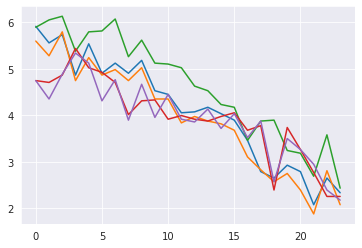

In [183]:
# Visualize 5 samples from test dataset
plt.plot(next(iter(train_loader))[0][0, :, :5, 0].detach().numpy())
plt.show()

In [184]:
from statistics import mean
        

def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for X, X_extra, y, edge_index in loader:
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, X_extra_gpu, edge_index)

            outs.append(out)
            ys.append(y_gpu)
            # print(out.shape, y.shape)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)
    # print(outs.shape)
    
    day_scores = [score_fn(outs[day], ys[day]).item() for day in range(len(ys))]
    return mean(losses), mean(day_scores)


def train(model, train_loader, val_loader,
    loss_fn, score_fn, optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        for X, X_extra, y, edge_index in train_loader:
            optimizer.zero_grad()
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, X_extra_gpu, edge_index)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            # sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
        
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [185]:
class MeanValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        # print(X.shape)
        out = torch.mean(X, dim=1)[:, :, 0]
        return out

class LastValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        out = X[:, -1, :, 0]
        return out

# for day value prediction only
class PreviousWeekValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = X[:, -7, :, 0]
        return out

class LinearModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, out_channels=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = encoder_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = nn.Linear(self.window * self.in_channels, self.out_channels)
    
    def forward(self, X, *args):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        X = X.reshape(batch_size, nodes_num, -1)
        
        out = self.lin(X)
        out = out[:, None]
        return out

class LSTMModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, hidden_size=8, num_layers=1, bidirectional=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.rnn.flatten_parameters()
        self.lin = nn.Linear(self.hidden_size * 2 if self.bidirectional else 1, 1)
    
    def forward(self, X, *args):
        batch_size = len(X)
        nodes_num = X.shape[1]
        X = X.reshape(-1, self.window, self.in_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = torch.squeeze(self.lin(out), -1)
        return out

class GNN_LSTMModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, gnn_hidden_dim=16,
     lstmcell_hidden_size=16, lstm_num_layers=1, bidirectional=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        
        self.gnn_hidden_dim = gnn_hidden_dim
        self.graph_layer = GCNConv(self.in_channels, self.gnn_hidden_dim)

        self.lstmcell_hidden_size = lstmcell_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.gnn_hidden_dim, hidden_size=self.lstmcell_hidden_size, 
            num_layers=self.lstm_num_layers, batch_first=True, bidirectional=self.bidirectional)

        self.lin = nn.Linear((2 if self.bidirectional else 1) * self.lstmcell_hidden_size, 1)
    
    def forward(self, X, edge_index):
        """X has shape [N, window, nodes_num, in_channels]
        edge_index has shape [N, 2, edges_num]

        Args:
            X (torch.Tensor): batched input features
            edge_index (torch.Tensor): adj list 

        Returns:
            torch.Tensor: predictions
        """
        batch_size = X.shape[0]
        nodes_num = X.shape[2]

        X = X.reshape(-1, nodes_num, self.in_channels)
        out = torch.stack([self.graph_layer(X[snap], edge_index[snap // self.window]) for snap in range(len(X))])
        # out = self.graph_layer(X, edge_index[0])
        out = out.reshape(batch_size, self.window, nodes_num, self.gnn_hidden_dim)

        out = out.transpose(1, 2)
        out = out.reshape(-1, self.window, self.gnn_hidden_dim)
        
        out, (hn, cn) = self.rnn(out)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = torch.squeeze(self.lin(out), -1)
        return out

In [186]:
class LinearWithExtraFeaturesModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = encoder_length
        self.in_channels = in_channels
        self.lin = nn.Linear(self.window * self.in_channels, 1)
    
    def forward(self, X, X_extra, *args):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        # print(X.shape, X_extra.shape)
        X_extra = X_extra.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        X = torch.cat((X, X_extra), dim=-1)
        X = X.reshape(batch_size, nodes_num, -1)
        out = self.lin(X)
        out = torch.squeeze(out, -1)
        return out


class LSTMWithExtraFeaturesModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, hidden_size=8, num_layers=1, bidirectional=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.rnn.flatten_parameters()
        self.lin = nn.Linear(self.hidden_size * 2 if self.bidirectional else 1, 1)
    
    def forward(self, X, X_extra, *args):
        X = X.transpose(1, 2)
        batch_size = len(X)
        nodes_num = X.shape[1]
        # print(X.shape, X_extra.shape)
        X_extra = X_extra.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        X = torch.cat((X, X_extra), dim=-1)
        X = X.reshape(-1, self.window, self.in_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = torch.squeeze(self.lin(out), -1)
        return out

In [187]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [188]:
# Train proccess runs with scaled targets (RNNs are very data demanding), 
# thus before counting score it needs unscaling targets
# to get score on the original data.
class UnscaledScore():
    def __init__(self, score_fn, scaler) -> None:
        self.score_fn = score_fn
        self.scaler = scaler
    def __call__(self, y_pred, y_true):
        y_pred = self.scaler.inverse_transform(y_pred)
        y_true = self.scaler.inverse_transform(y_true)
        return self.score_fn(y_pred.squeeze(), y_true.squeeze())

In [189]:
loss_fn = nn.MSELoss().to(device)
scaler = copy.deepcopy(ds.target_scaler).to(device)
score_fn = UnscaledScore(R2Score().to(device), scaler)
# score_fn = RMSELoss().to(device)

# Using last 6 hours to predict value in the next 15 minutes
def run(model, *args, **kwargs):
    results = dict()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=2, gamma=0.8)
        
    model = train(model, train_loader, val_loader,
        loss_fn, score_fn, optimizer, device, scheduler=scheduler, *args, **kwargs)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [190]:
import random

def evaluate_plot(model, loader, scaler, nodes_ids=nodes, nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))
    
    with torch.no_grad():
        for X, X_extra, y, edge_index in loader:
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, X_extra_gpu, edge_index)

            outs.append(out)
            ys.append(y_gpu)
        
        ys = scaler.inverse_transform(torch.vstack(ys)).detach().cpu().numpy()
        outs = scaler.inverse_transform(torch.vstack(outs)).detach().cpu().numpy()

        for idx, node in enumerate(random.choices(range(len(nodes_ids)), k=nodes_num)):
            axes[idx].set_title(nodes_ids[node])
            # axes[idx].plot(ds.y[test_loader.sampler.indices, node], label='actual', c='r')
            axes[idx].plot(ys[:, 0, node], label='actual', c='r')
            axes[idx].plot(outs[:, 0, node], label='pred', c='b')
            axes[idx].legend()
        plt.show()

**Linear Model**

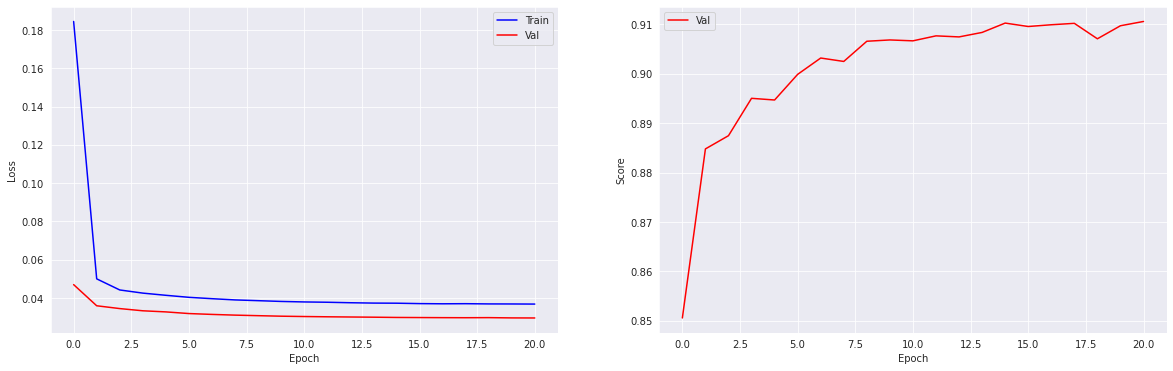

Type: LinearModel, Test loss: 0.04, Test score: 0.7989


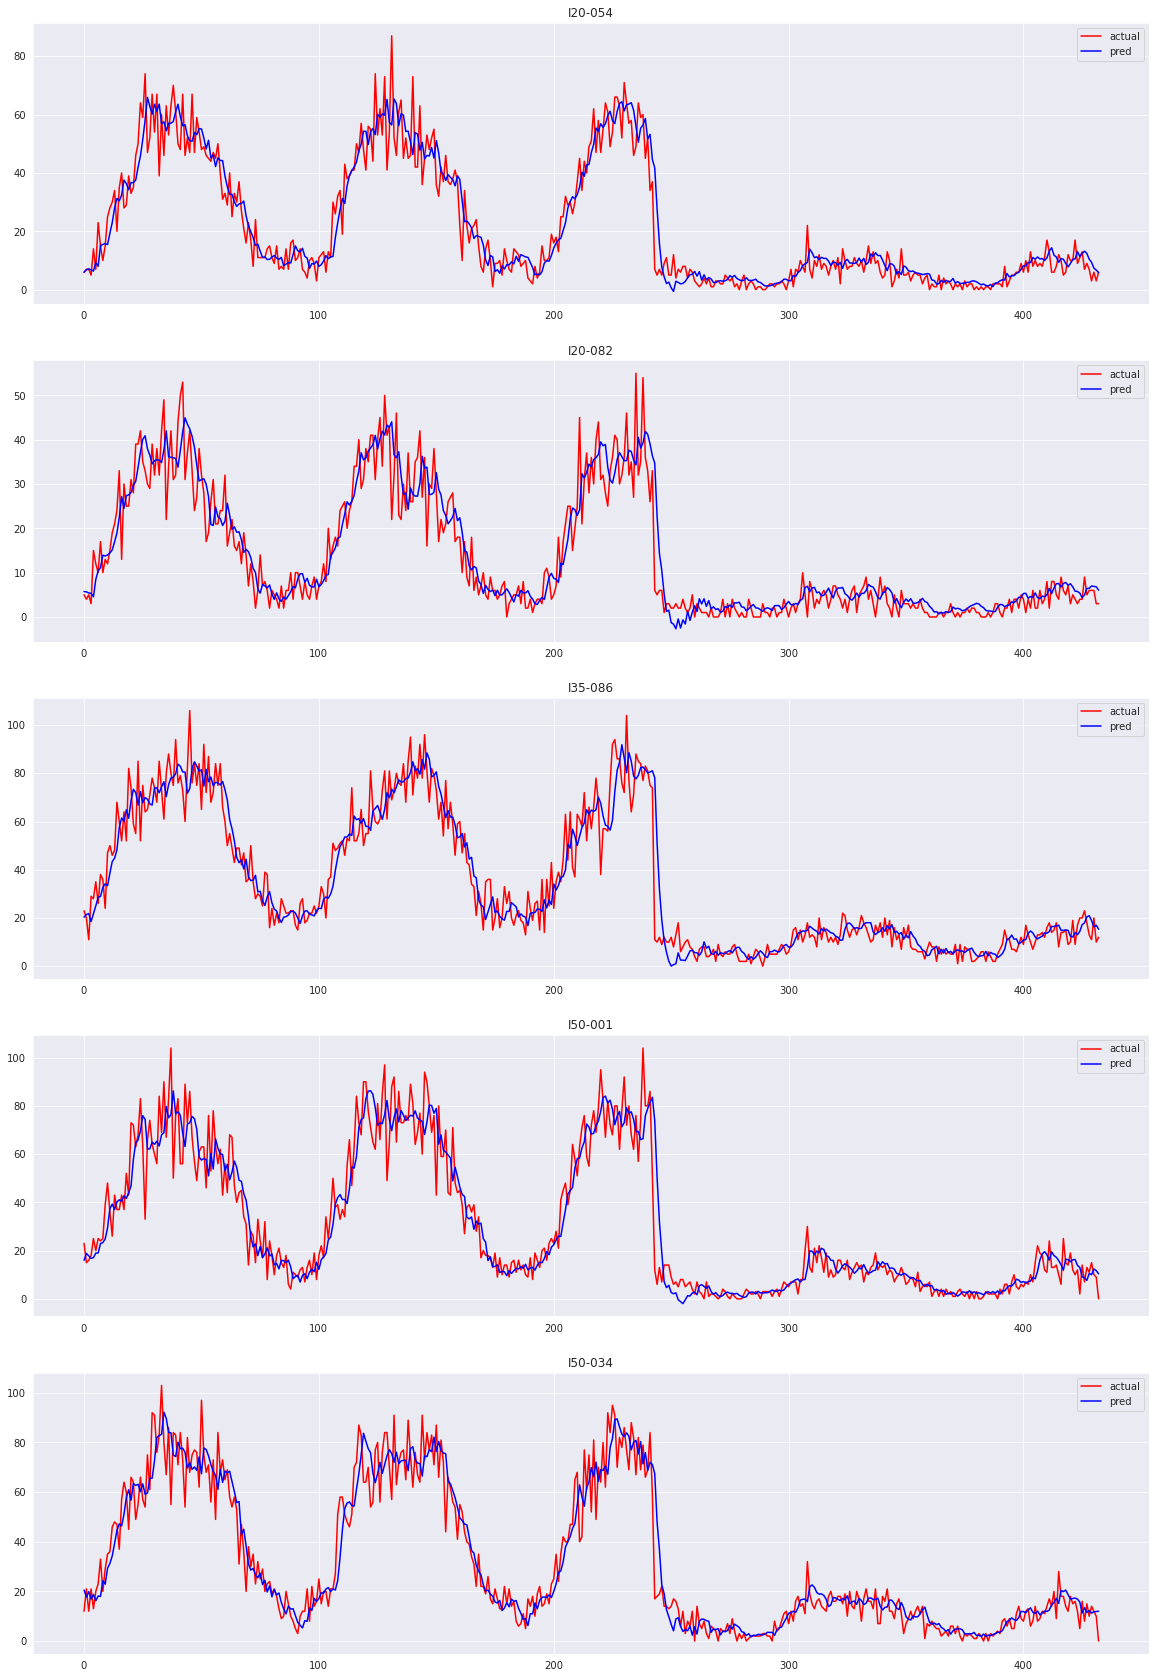

In [191]:
model = LinearModel(encoder_length=24, in_channels=2).to(device)
model = run(model, num_epochs=20, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**LSTM**

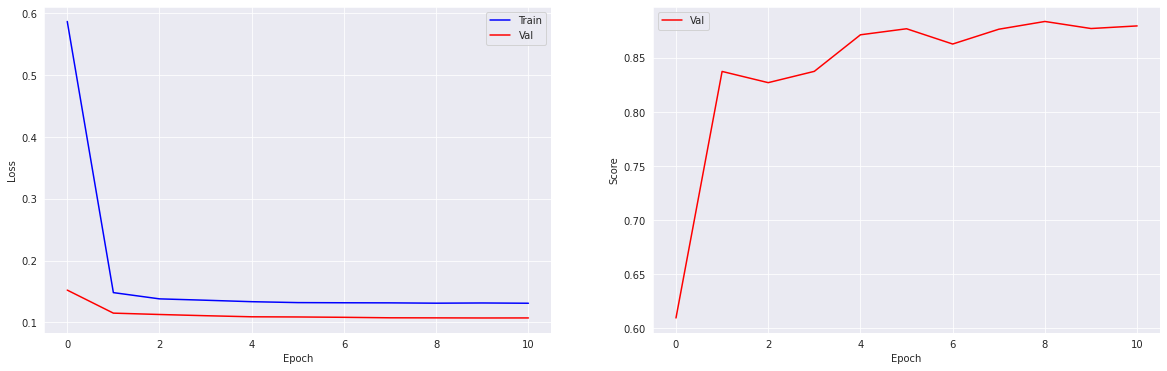

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: LSTMModel, Test loss: 0.14, Test score: 0.6805


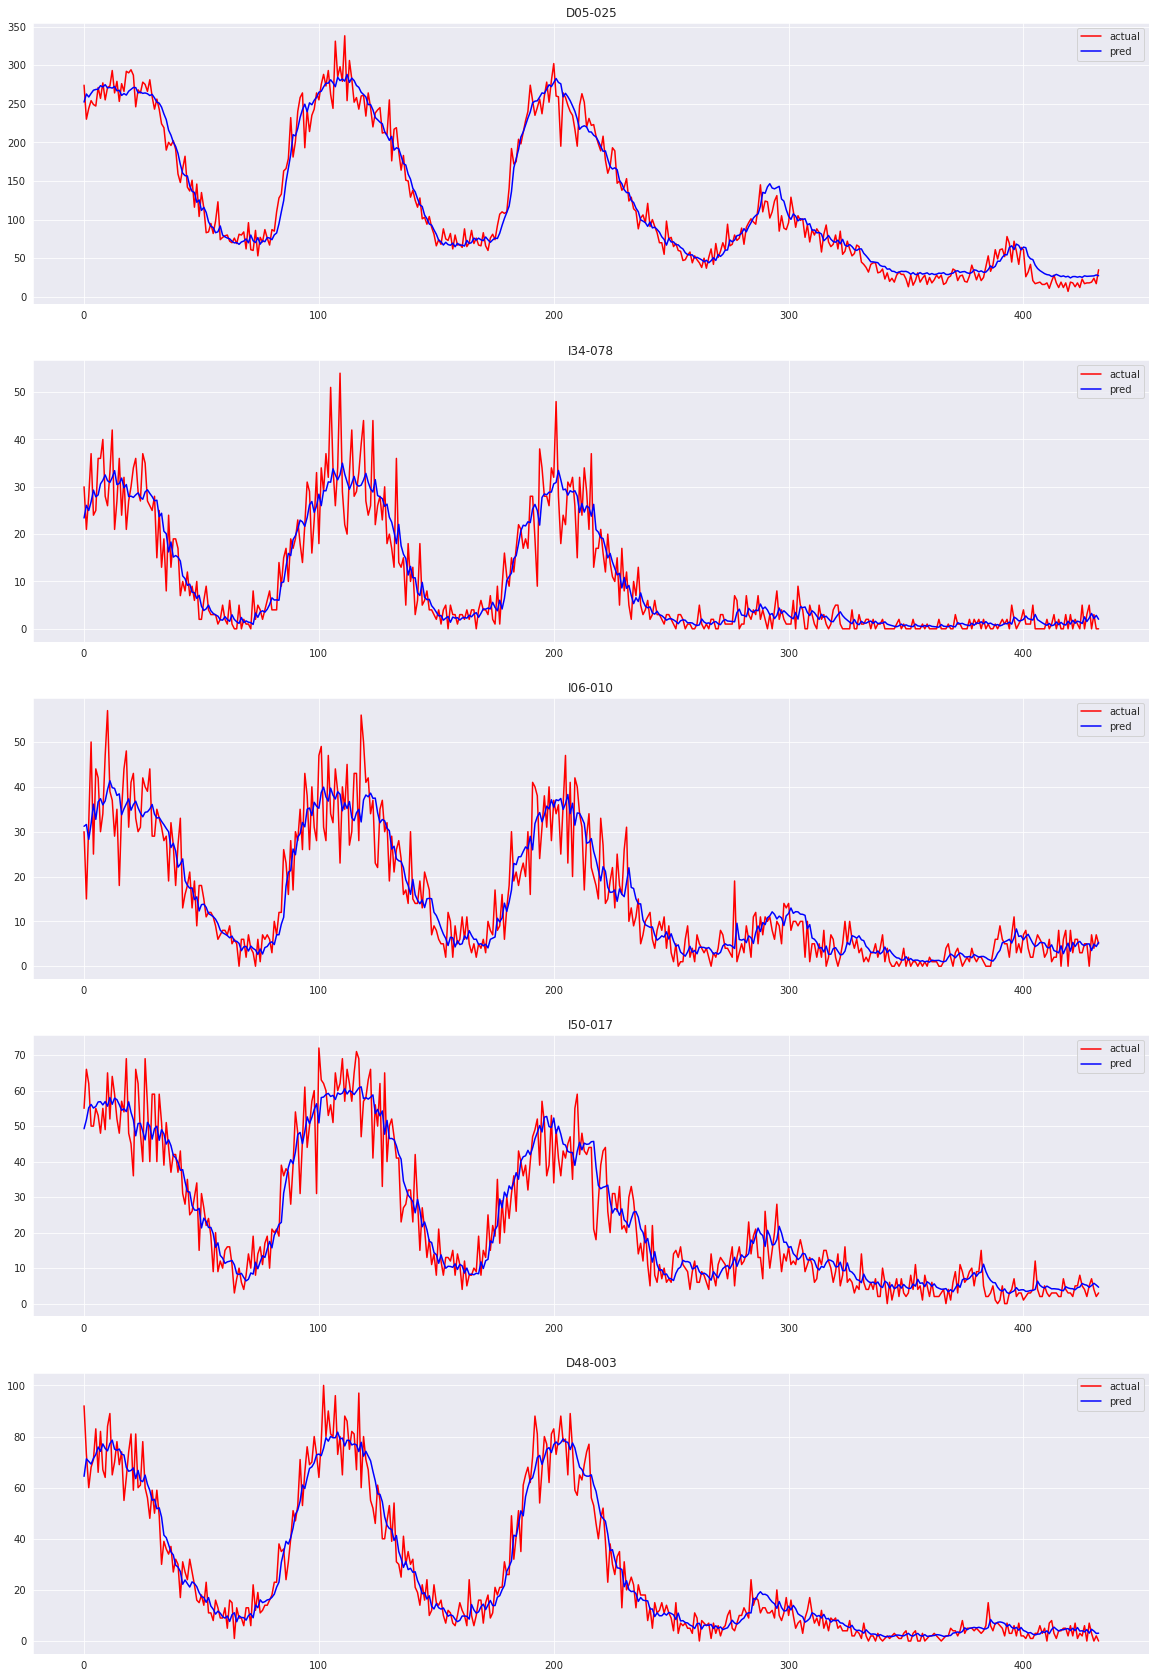

In [243]:
model = LSTMModel(encoder_length=24, in_channels=1).to(device)
model = run(model, num_epochs=10, plot=True, plot_update_freq=2)
evaluate_plot(model, val_loader, scaler)

**GNN + LSTM**

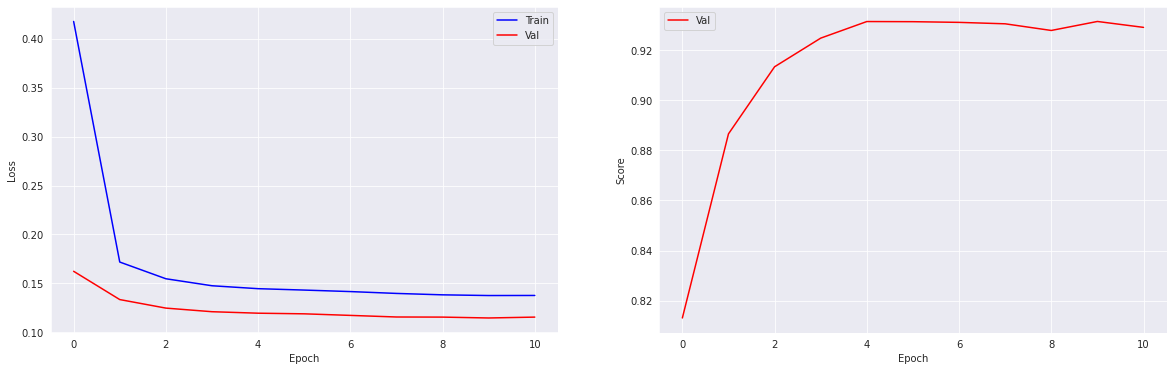

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: GNN_LSTMModel, Test loss: 0.14, Test score: 0.8970


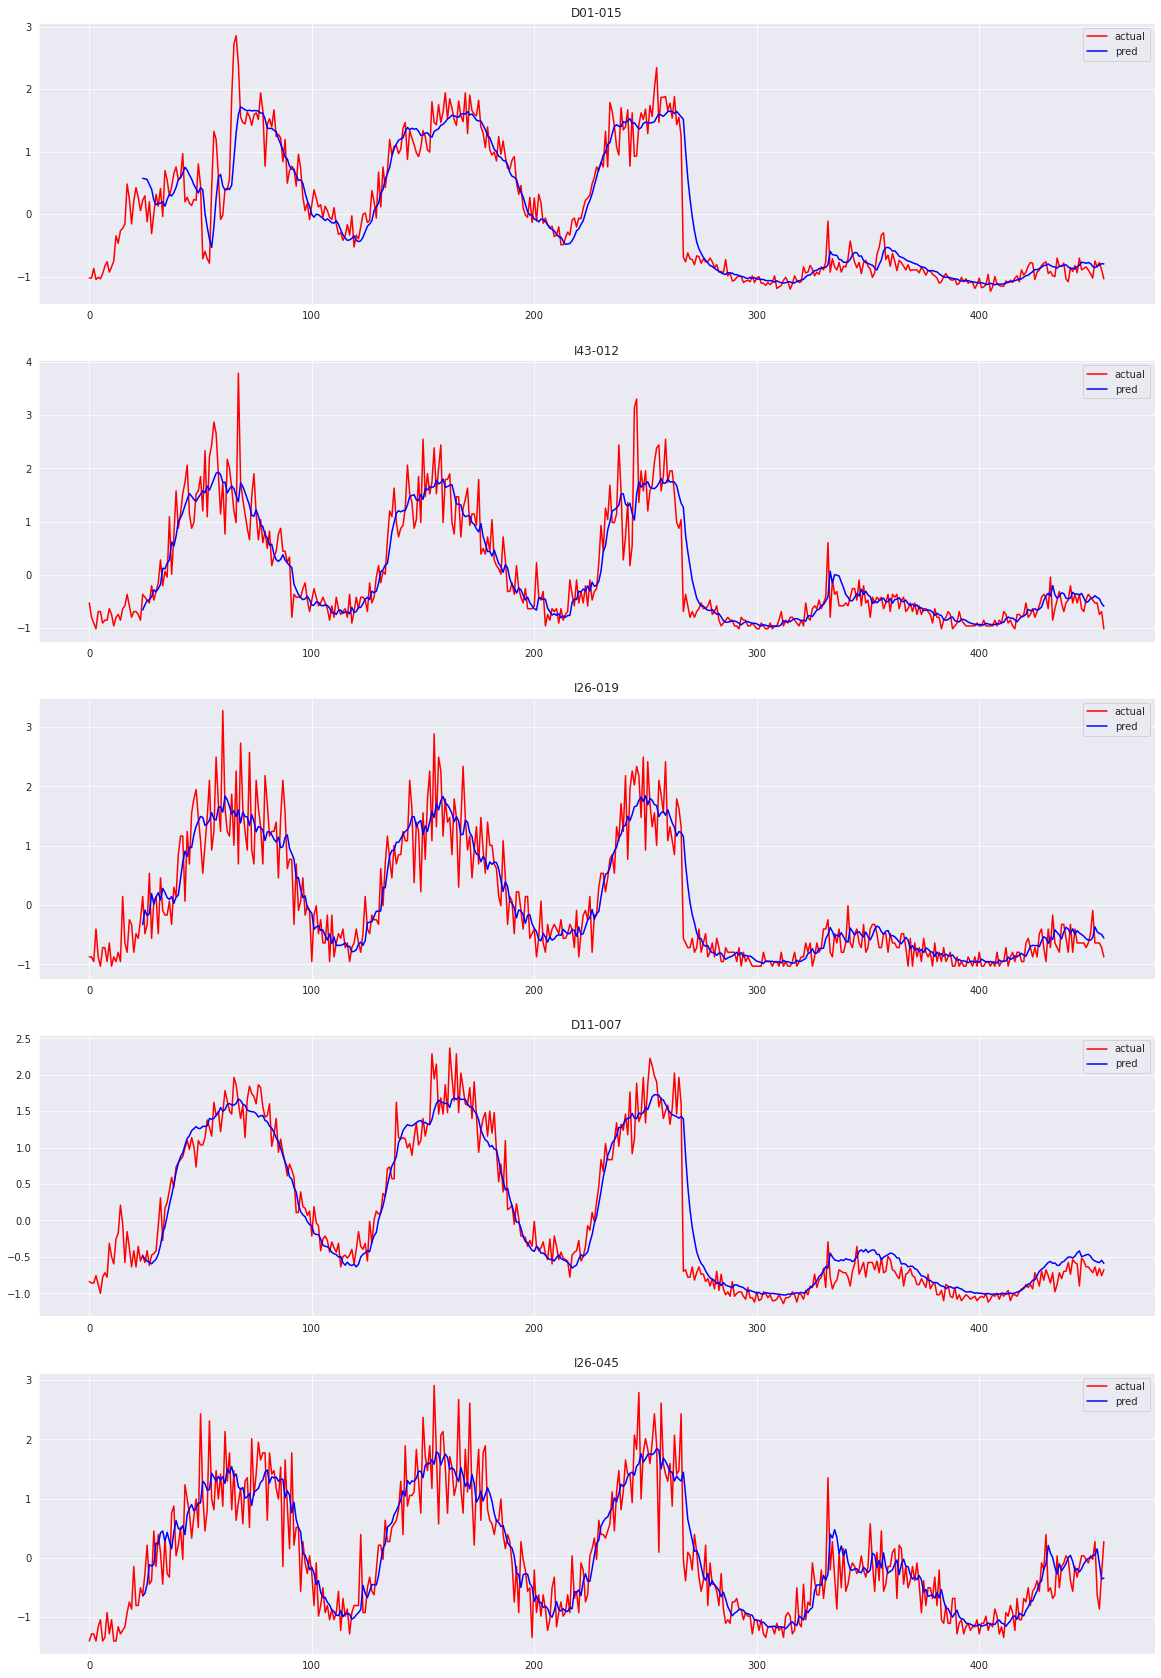

CPU times: user 8min 53s, sys: 3.06 s, total: 8min 56s
Wall time: 8min 57s


In [129]:
%%time
model = GNN_LSTMModel(encoder_length=24, in_channels=1).to(device)
model = run(model, num_epochs=10, plot=True, plot_update_freq=2)
evaluate_plot(model)